In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Load enriched data (already cleaned and feature engineered)
df = pd.read_csv('/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_USA.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Define feature columns
features = ['Close', 'MA_5', 'MA_20', 'Vol_10', 'RSI_14', 'MACD', 'Signal']

# Drop NaNs and prepare data
df.dropna(inplace=True)
X_raw = df[features].copy()
y_raw = df['Target'].copy()

In [3]:
X_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X_raw)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_raw.values.reshape(-1, 1))

In [4]:
def create_windows(X, y, window_size=60):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_tensor, y_tensor = create_windows(X_scaled, y_scaled.flatten())

In [5]:
def split_data(X, y, train_ratio=0.8):
    split = int(len(X) * train_ratio)
    return X[:split], X[split:], y[:split], y[split:]

X_train, X_test, y_train, y_test = split_data(X_tensor, y_tensor)

In [6]:
def build_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = X_train.shape[1:]
model = build_cnn_lstm_model(input_shape)

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
36/36 [==============================] - 1s 12ms/step - loss: 0.0204 - mae: 0.1043 - val_loss: 0.0021 - val_mae: 0.0336
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0036 - mae: 0.0468 - val_loss: 0.0038 - val_mae: 0.0523
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0029 - mae: 0.0422 - val_loss: 0.0033 - val_mae: 0.0480
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0026 - mae: 0.0395 - val_loss: 0.0033 - val_mae: 0.0483
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0024 - mae: 0.0390 - val_loss: 0.0027 - val_mae: 0.0434
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0355 - val_loss: 0.0031 - val_mae: 0.0466
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 0.0020 - val_mae: 0.0352
Epoch 8/100
36/36 [==============================] - 0s 11ms/step - loss: 0.0019 -

In [8]:
y_pred_scaled = model.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

9/9 [==============================] - 0s 2ms/step
Test RMSE: 146.15
Test MAE: 107.48


In [11]:
# -----------------------------------------------
# Step 7: Export for Power BI
# -----------------------------------------------
test_dates = df.index[-len(y_true):]

results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': y_true.flatten(),
    'Predicted_Close': y_pred.flatten(),
    'Market': 'USA'
})

results_df.to_csv("cnn_lstm_predictions_usa.csv", index=False)
print("Exported predictions for Power BI.")


Exported predictions for Power BI.


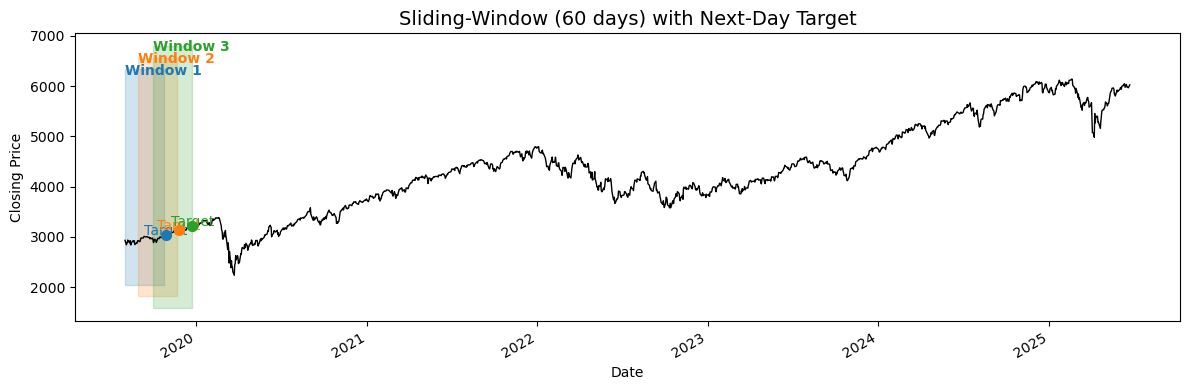

In [3]:
from matplotlib.patches import Rectangle

# --- 1) Load your cleaned CSV (e.g. for India) ---
df = pd.read_csv("/Users/rishabhsaudagar/Desktop/NCI CLG/SEMESTER 3/Thesis/Thesis_Dev/data/cleaned/Cleaned_USA.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# choose the column you want to plot (e.g. 'Close' or 'Adj Close')
series = df["Close"].values
dates  = df["Date"].values

# --- 2) Set window parameters ---
window_size = 60  # lookback length
step        = 20  # how far apart to show successive windows

# --- 3) Plot the time series ---
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dates, series, lw=1, color="black")

# --- 4) Overlay a few windows + next-day targets ---
for i, start in enumerate(range(0, 3*step, step)):
    end   = start + window_size - 1
    if end + 1 >= len(series): 
        break

    # draw shaded window
    ax.add_patch(Rectangle(
        (dates[start], ax.get_ylim()[0]),
        dates[end] - dates[start],
        ax.get_ylim()[1] - ax.get_ylim()[0],
        alpha=0.2,
        color=f"C{i}"
    ))
    # mark target point
    tgt_idx = end + 1
    ax.scatter(dates[tgt_idx], series[tgt_idx], color=f"C{i}", s=50, zorder=5)
    
    # annotate
    ax.text(dates[start], ax.get_ylim()[1]*0.95,
            f"Window {i+1}", color=f"C{i}", weight="bold")
    ax.text(dates[tgt_idx], series[tgt_idx]+0.5,
            "Target", ha="center", color=f"C{i}")

# --- 5) Tidy up ---
ax.set_title("Sliding-Window (60 days) with Next-Day Target", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()
